In [31]:
#!/usr/bin/env python3
import torch
import torch.nn as nn
import numpy as np
import einops
import os, sys, math, time
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from einops import rearrange, reduce, repeat
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, Resize, CenterCrop


# Check for GPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using PyTorch version {torch.__version__} with GPU...")
else:
    device = torch.device("cpu")
    print("Using CPU")


Using PyTorch version 2.3.0 with GPU...


#### FINE TUNING VISION TRANSFORMER

In [2]:
# Data preparation
dataset = load_dataset("Hemg/Brain-Tumor-MRI-Dataset")
split = dataset["train"].train_test_split(test_size=0.1)
train_ds = split["train"]
val_ds = split["test"]
num_classes = len(train_ds.features["label"].names)

# Dataset Class
class ViTDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"].convert("RGB")
        label = item["label"]

        if self.transform:
            image = self.transform(image)

        return {
            "pixel_values": image,
            "labels": torch.tensor(label, dtype=torch.long)
        }

# Model setup
model_name = "google/vit-base-patch16-224-in21k"
image_processor = ViTImageProcessor.from_pretrained(model_name)

# Create proper ViT transforms using processor's parameters
vit_transforms = Compose([
    Resize((image_processor.size["height"], image_processor.size["width"])),
    ToTensor(),
    Normalize(
        mean=image_processor.image_mean,
        std=image_processor.image_std
    ),
])

In [3]:
# create datasets with proper transforms
train_dataset = ViTDataset(train_ds, transform=vit_transforms)
val_dataset = ViTDataset(val_ds, transform=vit_transforms)

# Create model
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
).to(device)

def collate_fn(batch):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]).to(device),
        "labels": torch.tensor([x["labels"] for x in batch]).to(device)
    }
# Training Arguments
training_args = TrainingArguments(
    output_dir="./vit-brain-tumor",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=10,
    use_mps_device=True,
    fp16=False,
    dataloader_pin_memory=False,
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/miniconda3/envs/ml_env/lib/python3.10/site-packages/transformers/training_args.py:2243: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(


In [4]:
# Metrics function
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": accuracy_score(labels, predictions)}

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)

start_time = time.time()

# Start training
trainer.train()

# Calculate total time
total_time = time.time() - start_time

# Convert to readable format
minutes, seconds = divmod(total_time, 60)
hours, minutes = divmod(minutes, 60)
print(f"Total training time: {int(hours)}h {int(minutes)}m {int(seconds)}s")

# Save model
trainer.save_model("./vit-brain-tumor-final")

Epoch,Training Loss,Validation Loss,Accuracy
1,0.395100,0.135349,0.971550
2,0.082700,0.091081,0.978663
3,0.030300,0.058851,0.988620
4,0.016000,0.061867,0.988620
5,0.009600,0.061894,0.985775
6,0.007200,0.062238,0.985775
7,0.005800,0.064376,0.985775
8,0.004900,0.067255,0.985775
9,0.004400,0.068874,0.985775
10,0.004100,0.069515,0.985775


Total training time: 0h 35m 51s


In [5]:
# Training metrics
history = trainer.state.log_history

# Separate training and validation logs
train_logs = [log for log in history if "loss" in log and "eval_loss" not in log]
eval_logs = [log for log in history if "eval_loss" in log]

# Extract values
train_loss = [log["loss"] for log in train_logs]
eval_loss = [log["eval_loss"] for log in eval_logs]
eval_acc = [log["eval_accuracy"] for log in eval_logs]
epochs = list(range(1, len(train_loss)+1))

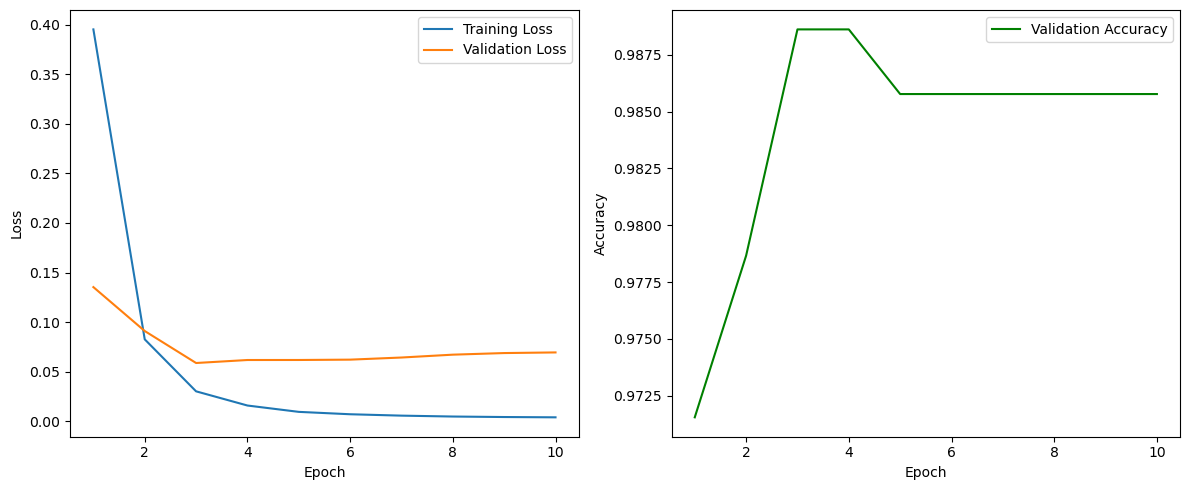

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, eval_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, eval_acc, label="Validation Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("./vit_stats.png")
plt.show()

In [ ]:
# inference
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import torch
import time

# Load fine-tuned components
model_path = "vit-brain-tumor-final"
model = ViTForImageClassification.from_pretrained(model_path).to("mps")
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# inference function
def predict(image_path, num_runs=10):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(image, return_tensors="pt").to("mps")
    
    # warmup
    with torch.no_grad():
        _ = model(**inputs)

    # timed inference
    start_time = time.time()
    with torch.no_grad():
        outputs = model(**inputs)
    inference_time = time.time() - start_time

    # average over multiple runs
    total_time = 0
    for _ in range(num_runs):
        start = time.time()
        with torch.no_grad():
            _ = model(**inputs)
        total_time += time.time() - start
    
    # Get predictions
    logits = outputs.logits
    predicted_class = logits.argmax(-1).item()
    
    return {
        "prediction": predicted_class,
        "inference_time_single": inference_time,
        "inference_time_avg": total_time / num_runs,
        "probabilities": torch.nn.functional.softmax(logits, dim=-1)
    }

In [ ]:
result = predict("images/_0_0.png")
result

{'prediction': 0,
 'inference_time_single': 0.48470020294189453,
 'inference_time_avg': 0.02875988483428955,
 'probabilities': tensor([[0.9815, 0.0059, 0.0061, 0.0064]], device='mps:0')}

In [17]:
image_processor

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
# Get predictions on validation set
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Get class names
class_names = val_ds.features["label"].names

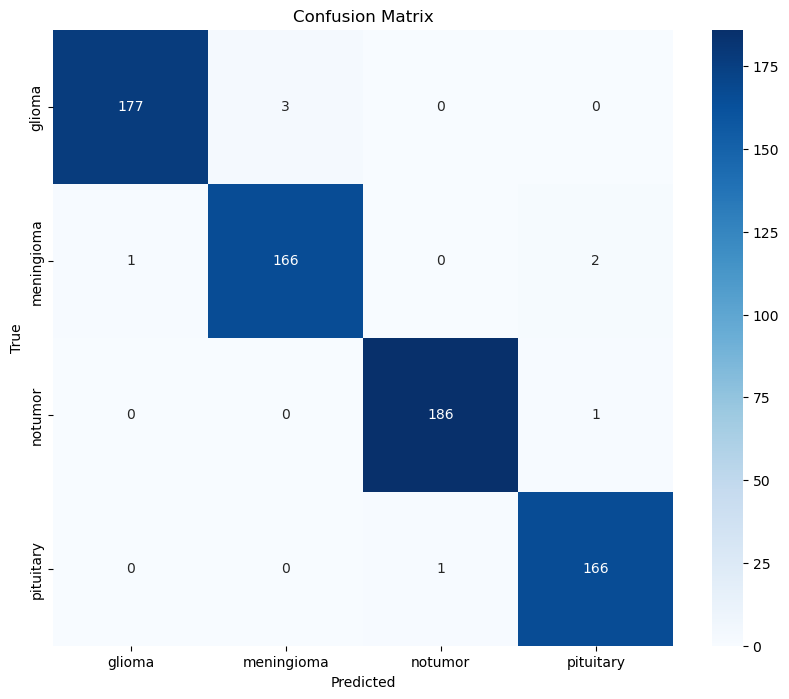

In [34]:
# classifcation report and confusion matrix
def plot_confusion_matrix(labels, preds, class_names):
    cm = confusion_matrix(labels, preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", 
                xticklabels=class_names, 
                yticklabels=class_names,
                cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.savefig("./confusion_matrix_vit.png")
    plt.show()

plot_confusion_matrix(labels, preds, class_names=class_names)

In [29]:
print(classification_report(labels, preds, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.99      0.98      0.99       180
  meningioma       0.98      0.98      0.98       169
     notumor       0.99      0.99      0.99       187
   pituitary       0.98      0.99      0.99       167

    accuracy                           0.99       703
   macro avg       0.99      0.99      0.99       703
weighted avg       0.99      0.99      0.99       703



In [33]:
len(val_dataset)

703